In [ ]:
from dotenv import load_dotenv
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [1]:
import sys
import os

# Add the scripts folder to the Python path
scripts_path = os.path.abspath('../scripts')
print(f"Scripts path: {scripts_path}")
sys.path.append(scripts_path)

# Now import the required functions
try:
    from data_extraction import load_data_from_postgres, load_data_using_sqlalchemy
    from sql_queries import execute_telecom_queries
    print("Imports successful")
except ImportError as e:
    print(f"Error importing modules: {e}")

Scripts path: /home/dura/Codes/week2/scripts
Imports successful


In [2]:
# SQL query
query = "SELECT * FROM xdr_data;"  

# Load data from PostgreSQL
df = load_data_from_postgres(query)

# Display the first few rows of the dataframe
if df is not None:
    print("Successfully loaded the data")
else:
    print("Failed to load data.")

/home/dura/Codes/week2/scripts/data_extraction.py:38: UserWarning: pandas only supports SQLAlchemy connectable (engine/connection) or database string URI or sqlite3 DBAPI2 connection. Other DBAPI2 objects are not tested. Please consider using SQLAlchemy.
  df = pd.read_sql_query(query, connection)


Successfully loaded the data


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 149010 non-null  float64
 1   Start                                     150000 non-null  object 
 2   Start ms                                  150000 non-null  float64
 3   End                                       150000 non-null  object 
 4   End ms                                    150000 non-null  float64
 5   Dur. (ms)                                 150000 non-null  float64
 6   IMSI                                      149431 non-null  float64
 7   MSISDN/Number                             148935 non-null  float64
 8   IMEI                                      149429 non-null  float64
 9   Last Location Name                        148848 non-null  object 
 10  Avg RTT DL (ms)     

In [8]:
import pandas as pd
import numpy as np

# Assuming df is the DataFrame containing the dataset
# Inspect the data
print("Data Overview:")
print(df.info())
print(df.describe())

# Handle missing values
for column in df.columns:
    if df[column].dtype in ['float64', 'int64']:
        df[column] = df[column].fillna(df[column].mean())
    else:
        df[column] = df[column].fillna(df[column].mode()[0])

# Handle outliers (using IQR)
for column in df.select_dtypes(include=['float64', 'int64']).columns:
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    df[column] = df[column].clip(lower=lower_bound, upper=upper_bound)

# Aggregate information per customer
customer_aggregates = df.groupby('MSISDN/Number').agg({
    'TCP DL Retrans. Vol (Bytes)': 'mean',
    'Avg RTT DL (ms)': 'mean',
    'Handset Type': 'first',
    'Avg Bearer TP DL (kbps)': 'mean'
}).reset_index()

# Rename columns for clarity
customer_aggregates.rename(columns={
    'TCP DL Retrans. Vol (Bytes)': 'avg_tcp_retransmission',
    'Avg RTT DL (ms)': 'avg_rtt',
    'Handset Type': 'handset_type',
    'Avg Bearer TP DL (kbps)': 'avg_throughput'
}, inplace=True)

print("Aggregated customer information:")
print(customer_aggregates.head())

Data Overview:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 150001 entries, 0 to 150000
Data columns (total 55 columns):
 #   Column                                    Non-Null Count   Dtype  
---  ------                                    --------------   -----  
 0   Bearer Id                                 150001 non-null  float64
 1   Start                                     150001 non-null  object 
 2   Start ms                                  150001 non-null  float64
 3   End                                       150001 non-null  object 
 4   End ms                                    150001 non-null  float64
 5   Dur. (ms)                                 150001 non-null  float64
 6   IMSI                                      150001 non-null  float64
 7   MSISDN/Number                             150001 non-null  float64
 8   IMEI                                      150001 non-null  float64
 9   Last Location Name                        150001 non-null  object 
 10  Avg R

In [9]:
# Compute top, bottom, and most frequent values for TCP, RTT, and Throughput
top_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nlargest(10)
bottom_10_tcp = df['TCP DL Retrans. Vol (Bytes)'].nsmallest(10)
most_frequent_tcp = df['TCP DL Retrans. Vol (Bytes)'].value_counts().head(10)

top_10_rtt = df['Avg RTT DL (ms)'].nlargest(10)
bottom_10_rtt = df['Avg RTT DL (ms)'].nsmallest(10)
most_frequent_rtt = df['Avg RTT DL (ms)'].value_counts().head(10)

top_10_throughput = df['Avg Bearer TP DL (kbps)'].nlargest(10)
bottom_10_throughput = df['Avg Bearer TP DL (kbps)'].nsmallest(10)
most_frequent_throughput = df['Avg Bearer TP DL (kbps)'].value_counts().head(10)

print("Top 10 TCP values:")
print(top_10_tcp)
print("Bottom 10 TCP values:")
print(bottom_10_tcp)
print("Most frequent TCP values:")
print(most_frequent_tcp)

print("Top 10 RTT values:")
print(top_10_rtt)
print("Bottom 10 RTT values:")
print(bottom_10_rtt)
print("Most frequent RTT values:")
print(most_frequent_rtt)

print("Top 10 Throughput values:")
print(top_10_throughput)
print("Bottom 10 Throughput values:")
print(bottom_10_throughput)
print("Most frequent Throughput values:")
print(most_frequent_throughput)

Top 10 TCP values:
147    5.002539e+07
175    5.002539e+07
440    5.002539e+07
538    5.002539e+07
555    5.002539e+07
557    5.002539e+07
566    5.002539e+07
578    5.002539e+07
606    5.002539e+07
655    5.002539e+07
Name: TCP DL Retrans. Vol (Bytes), dtype: float64
Bottom 10 TCP values:
59717     2.0
125094    2.0
2850      4.0
39610     4.0
52488     4.0
60376     4.0
60426     4.0
75093     4.0
100314    4.0
143429    4.0
Name: TCP DL Retrans. Vol (Bytes), dtype: float64
Most frequent TCP values:
TCP DL Retrans. Vol (Bytes)
2.080991e+07    88146
5.002539e+07     2525
1.330000e+03      433
2.660000e+03      219
3.800000e+01      200
9.200000e+01      192
1.318000e+03      156
5.430000e+02      133
3.990000e+03      114
7.600000e+01      108
Name: count, dtype: int64
Top 10 RTT values:
20     221.989265
30     221.989265
68     221.989265
154    221.989265
351    221.989265
385    221.989265
420    221.989265
467    221.989265
470    221.989265
471    221.989265
Name: Avg RTT DL (ms

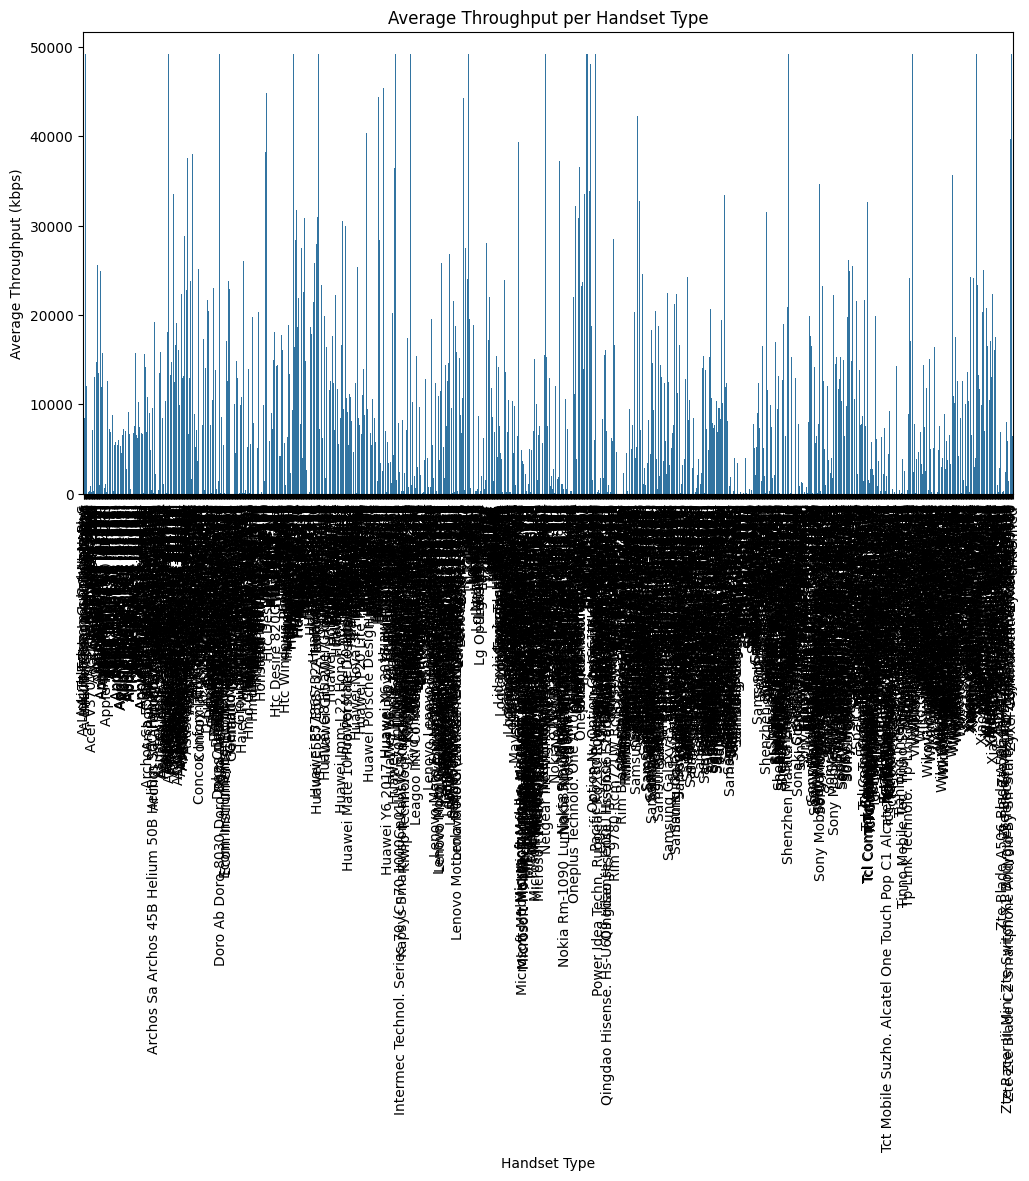

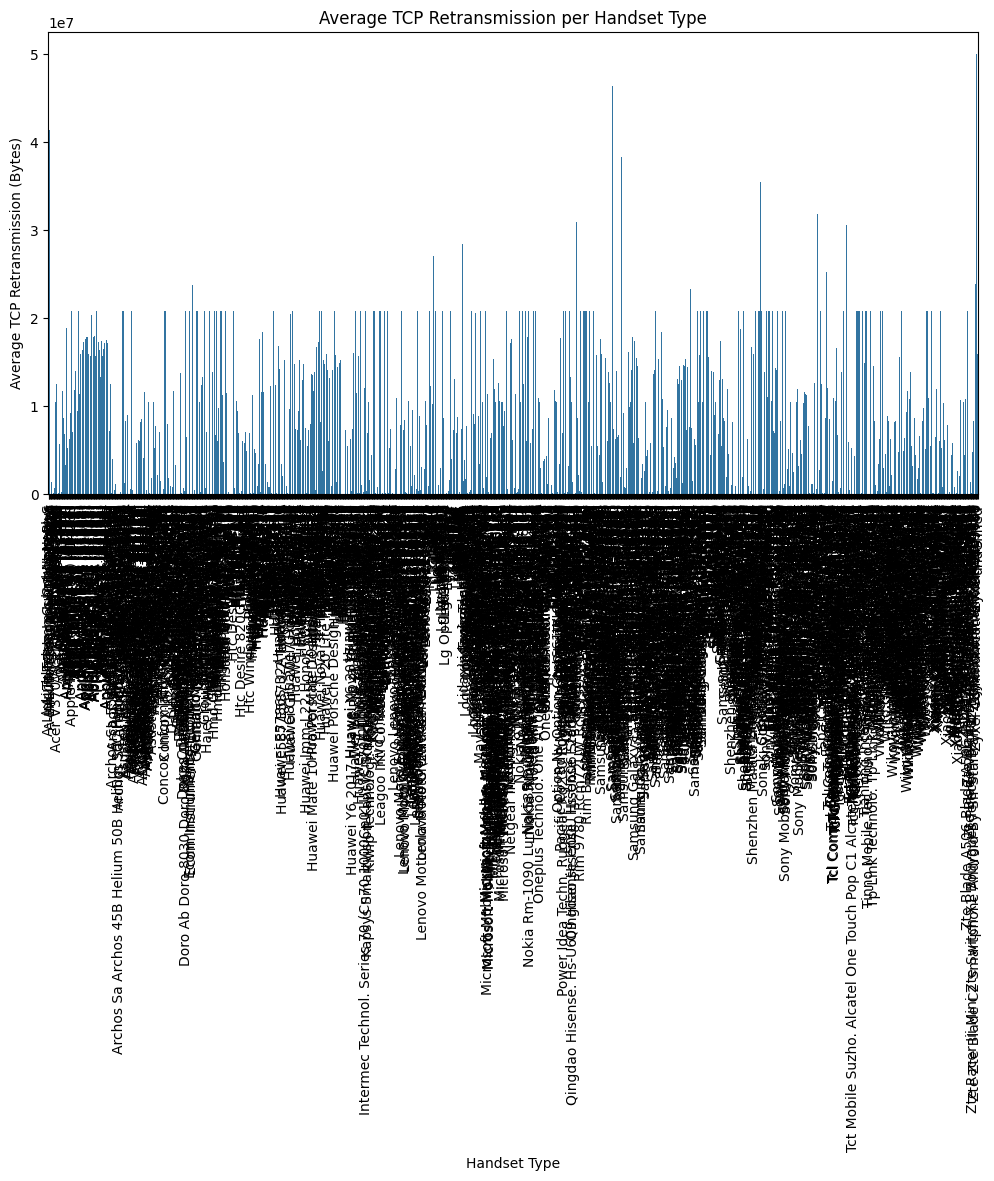

In [14]:
import matplotlib.pyplot as plt
import seaborn as sns

# Distribution of average throughput per handset type
throughput_distribution = customer_aggregates.groupby('handset_type')['avg_throughput'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='handset_type', y='avg_throughput', data=throughput_distribution)
plt.xticks(rotation=90)
plt.title('Average Throughput per Handset Type')
plt.xlabel('Handset Type')
plt.ylabel('Average Throughput (kbps)')
plt.show()

# Average TCP retransmission per handset type
tcp_retransmission_distribution = customer_aggregates.groupby('handset_type')['avg_tcp_retransmission'].mean().reset_index()

plt.figure(figsize=(12, 6))
sns.barplot(x='handset_type', y='avg_tcp_retransmission', data=tcp_retransmission_distribution)
plt.xticks(rotation=90)
plt.title('Average TCP Retransmission per Handset Type')
plt.xlabel('Handset Type')
plt.ylabel('Average TCP Retransmission (Bytes)')
plt.show()

In [12]:
from sklearn.cluster import KMeans

# Prepare the data for clustering
X = customer_aggregates[['avg_tcp_retransmission', 'avg_rtt', 'avg_throughput']]

# Run K-Means clustering with k=3
kmeans = KMeans(n_clusters=3, random_state=42)
customer_aggregates['experience_cluster'] = kmeans.fit_predict(X)

print("Cluster assignments:")
print(customer_aggregates['experience_cluster'].value_counts())

# Brief description of each cluster
cluster_descriptions = customer_aggregates.groupby('experience_cluster').agg({
    'avg_tcp_retransmission': 'mean',
    'avg_rtt': 'mean',
    'avg_throughput': 'mean'
}).reset_index()

print("Cluster descriptions:")
print(cluster_descriptions)

Cluster assignments:
experience_cluster
1    52877
0    23494
2    13667
Name: count, dtype: int64
Cluster descriptions:
   experience_cluster  avg_tcp_retransmission    avg_rtt  avg_throughput
0                   0            9.446099e+05  89.974194    21295.822262
1                   1            2.163119e+07  67.724162     2608.207181
2                   2            1.097815e+07  71.057598    16985.834989
